In [5]:
from __future__ import print_function

import pandas as pd 
import numpy as np 
import sklearn

# NLTK/NLP
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
from nltk import FreqDist, word_tokenize
import string, re
import urllib
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.collocations import *
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import KeyedVectors

# Classifiers 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split
import scikitplot as skplt

#Sampling
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import sklearn.decomposition as decomposition

#Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")

import csv

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

import pickle
%run my_functions.ipynb

## Load Previously Cleaned Dataset

In [6]:
with open('data/cleaned-reshuffled.pkl', 'rb') as f:
	df = pickle.load(f)

In [7]:
df.head()

,id,label,tweet,tidy_tweet,no_hash_tweet,tokenized_tweet,stemmed_tokens,lemmatized_tokens,lem_tweet,stem_tweet
0,29727,0,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre #engrus...,sad to see the scenes of hooligans pre engrus ...,"[sad, to, see, the, scenes, of, hooligans, pre...","[sad, to, see, the, scene, of, hooligan, pre, ...","[sad, to, see, the, scene, of, hooligan, pre, ...",sad to see the scenes of hooligans pre engrus ...,sad to see the scenes of hooligans pre engrus ...
1,14466,0,#gooddyeyoung #yoyoyo !! super happy to be ap...,#gooddyeyoung #yoyoyo super happy to be apa of...,gooddyeyoung yoyoyo super happy to be apa of t...,"[gooddyeyoung, yoyoyo, super, happy, to, be, a...","[gooddyeyoung, yoyoyo, super, happi, to, be, a...","[gooddyeyoung, yoyoyo, super, happy, to, be, a...",gooddyeyoung yoyoyo super happy to be apa of t...,gooddyeyoung yoyoyo super happy to be apa of t...
2,18194,0,queen evil's bihdayð#lnic #lnicjustanevilbd...,queen evil s bihday #lnic #lnicjustanevilbday ...,queen evil s bihday lnic lnicjustanevilbday bi...,"[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...","[queen, evil, s, bihday, lnic, lnicjustanevilb...",queen evil s bihday lnic lnicjustanevilbday bi...,queen evil s bihday lnic lnicjustanevilbday bi...
3,18283,1,@user you might be a libtard if... #libtard #...,you might be a libtard if #libtard #sjw #liber...,you might be a libtard if libtard sjw liberal ...,"[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...","[you, might, be, a, libtard, if, libtard, sjw,...",you might be a libtard if libtard sjw liberal ...,you might be a libtard if libtard sjw liberal ...
4,25845,0,what are your goals? find out here... #smile...,what are your goals find out here #smile,what are your goals find out here smile,"[what, are, your, goals, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]","[what, are, your, goal, find, out, here, smile]",what are your goals find out here smile,what are your goals find out here smil


## Split Data into Train, Validation and Test Sets:

In [8]:
X = df.drop(['label'], axis = 1)

In [9]:
y = df['label']

In [46]:
y.value_counts(normalize = True)

0    0.929854
1    0.070146
Name: label, dtype: float64

In [10]:
#splitting into train and test 
X_model, X_test, y_model, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state=123)

In [11]:
#splitting "model" into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, stratify = y_model, test_size=0.20, random_state=123)

## Tuning and Testing Classifier Performance:

The performance of five classifiers (Multinomial Naive Bayes, Support Vector Machine, Logistic Regression, Random Forest and AdaBoost) were initially tested and compared, using different methods for: 

- text cleaning (tokenizing, stemming and lemmatizing)
- correcting for class imbalance (oversampling, undersampling, SMOTE and class weights)
- text vectorization methods - count vectorizer, tfidf vectorizer, tfidf with 1-2 n-grams, tfidf with 2-3 ngrams; word embedding methods using Word2Vec and GLoVe were also explored.

Logistic Regression had the best performance from early testing.  Tuning and testing of the final model is shown below.


### Grid Searching for Best Hyperparameters for Logistic Regression:

In [12]:
np.random.seed(10)
count_vect = CountVectorizer()
logreg = LogisticRegression(random_state= 10)

c_space = np.linspace (.1, 10, 100)
# c_space = np.logspace(-5, 8, 15)

parameters = {'C': c_space, 
          'penalty': ['l1', 'l2']}

scores = ['accuracy','recall','precision','f1']

lr_gs = GridSearchCV(logreg, param_grid = parameters, 
                           verbose = 0, scoring = scores, cv = 3, refit = 'f1')

In [13]:
#upsampling was used to correct for class imbalances based on earlier testing:

lr_gs_model, lr_X_val, lr_y_train_pred, lr_y_val_pred, \
                lr_y_val_prob, lr_metrics_dict, lr_pred_df = \
wrapper_single_vectorization(X_train.lem_tweet, y_train, X_val.lem_tweet, 
                y_val, lr_gs, count_vect, sampling= 'upsample')

In [14]:
lr_gs_model.best_params_

{'C': 8.4, 'penalty': 'l1'}

In [15]:
lr_metrics_dict

{'Train Accuracy': 1.0,
 'Train Precision': 1.0,
 'Train Recall': 1.0,
 'Train F1': 1.0,
 'Validation Accuracy': 0.95,
 'Validation Precision': 0.65,
 'Validation Recall': 0.66,
 'Validation F1': 0.65}

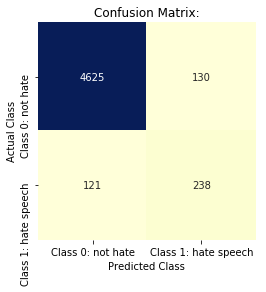

In [16]:
#before threshhold adjustment
seaborn_confusion_matrix(y_val, lr_y_val_pred)

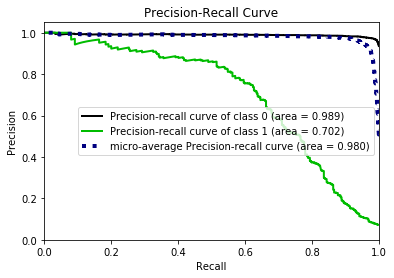

In [17]:
skplt.metrics.plot_precision_recall_curve(y_val, lr_y_val_prob)

Adjusted Accuracy: 0.9587407117716074
Adjusted Precision: 0.7466666666666667
Adjusted Recall: 0.6239554317548747
Adjusted F1 Score: 0.6798179059180577




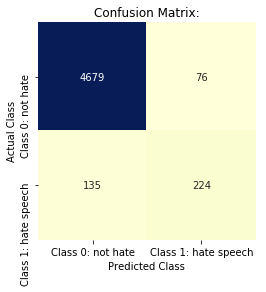

In [18]:
#with threshold adjustment
lr_pred_adj, cm = adjust_threshold_and_score(y_val, lr_y_val_prob, .2)

## Final Logistic Regression Model

In [19]:
lr_final_model, lr_X_val, lr_y_train_pred, lr_y_val_pred, \
                lr_y_val_prob, lr_metrics_dict, lr_pred_df = \
wrapper_single_vectorization(X_model.lem_tweet, y_model, X_test.lem_tweet, 
                y_test, LogisticRegression(C = 8.4, penalty = 'l1', random_state = 10), 
                count_vect, sampling= 'upsample')

In [21]:
print_classification_report(y_test, lr_y_val_pred)

              precision    recall  f1-score   support

    not hate       0.97      0.98      0.98      5945
 hate speech       0.68      0.67      0.67       448

    accuracy                           0.95      6393
   macro avg       0.83      0.82      0.82      6393
weighted avg       0.95      0.95      0.95      6393



Adjusted Accuracy: 0.9583919912404192
Adjusted Precision: 0.7433155080213903
Adjusted Recall: 0.6205357142857143
Adjusted F1 Score: 0.6763990267639903




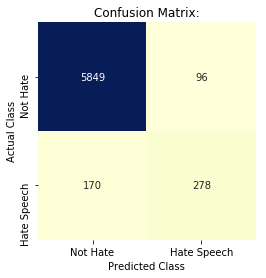

In [44]:
lr_y_test_adj, cm = adjust_threshold_and_score(y_test, lr_y_val_prob, .2)

### Exploring Misclassified Tweets in Test Set: 

In [25]:
lr_pred_df['adjusted class'] = lr_y_test_adj

In [29]:
lr_misclassified = lr_pred_df[lr_pred_df['adjusted class'] != lr_pred_df['actual class']]

In [31]:
lr_misclassified.shape

(266, 5)

In [36]:
lr_misclassified.head(15)

,prob 0,prob 1,predicted class,actual class,adjusted class
6161,0.99,0.01,0,1,0
30958,0.98,0.02,0,1,0
27842,1.00,0.00,0,1,0
3139,0.01,0.99,1,0,1
16925,0.62,0.38,0,1,0
13437,1.00,0.00,0,1,0
18929,0.07,0.93,1,0,1
5583,0.00,1.00,1,0,1
22916,1.00,0.00,0,1,0
9349,1.00,0.00,0,1,0


#### Actually Hate Speech, Classified as Not:

In [37]:
df['tidy_tweet'][22916]

'get your own house in order when you returning stolen land #hypocrite #liar #inhumane'

In [34]:
df['tidy_tweet'][30958]

'everytime i wear soccer shis joie fries me and says i look mexican as fuck'

#### Not Hate Speech, Classified as Hate Speech:

In [39]:
df['tidy_tweet'][7966]

'tweeted the exact same thing mins ago i can t stand she is such a nasty bitch amp so false looking'

In [48]:
df['tidy_tweet'][7162]

'i really should have gotten more credit for this one #maga #trump #quotes #quote #potus #news #media'